### Imports

In [1]:
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/CAPS') # Change this to your desired directory

MessageError: Error: credential propagation was unsuccessful

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, constraints, backend as K
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf

# Fix the seed value you want to use
SEED_VALUE = 42

# 1) Set PYTHONHASHSEED environment variable
os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)

# 2) Set python's built-in "random" module seed
random.seed(SEED_VALUE)

# 3) Set NumPy random seed
np.random.seed(SEED_VALUE)

# 4) Set TensorFlow random seed
tf.random.set_seed(SEED_VALUE)

# 5) (Optional but helpful) Force TF to use deterministic ops
os.environ['TF_DETERMINISTIC_OPS'] = '1'


### Data Preprocessing

In [ ]:
import pandas as pd

# Load the dataset
file_path = "Spectra_Abhin_reduced.csv"  # Update with your local path
acsm_data = pd.read_csv(file_path)

# Exclude the Time column
time_column = acsm_data['Time']
acsm_features = acsm_data.iloc[:, 1:]  # Exclude Time

# Compute Min-Max Normalization while preserving negatives
min_val = acsm_features.min().min()
max_val = acsm_features.max().max()
acsm_scaled_shifted = (acsm_features - min_val) / (max_val - min_val)

# Convert back to DataFrame
acsm_scaled_shifted_df = pd.DataFrame(acsm_scaled_shifted, columns=acsm_features.columns)

# Save processed dataset if needed
acsm_scaled_shifted_df.to_csv('normalized_acsm_data.csv', index=False)

print('Normalization complete. Data saved as normalized_acsm_data.csv')


Normalization complete. Data saved as normalized_acsm_data.csv


### Auto Encoder Implementation

In [ ]:
# --------------------------------------------------
# 1. Clustering Layer (for Deep Embedded Clustering)
# --------------------------------------------------
class ClusteringLayer(layers.Layer):
    """
    Clustering layer that converts latent vectors to soft cluster assignments.
    Uses a Student's t-distribution (as per DEC/DCEC).
    """
    def __init__(self, n_clusters, alpha=1.0, **kwargs):
        super().__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.cluster_centers = None

    def build(self, input_shape):
        # input_shape = (None, latent_dim)
        self.cluster_centers = self.add_weight(
            shape=(self.n_clusters, int(input_shape[1])),
            initializer='glorot_uniform',
            trainable=True,
            name='cluster_centers'
        )
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        """
        Student's t-distribution to compute soft assignments:
            q_ij = (1 + ||z_i - \mu_j||^2 / alpha) ^ -(alpha+1)/2
        """
        # Expand dims so we have (batch_size, 1, latent_dim)
        # Compare each latent vector to each cluster center
        q = 1.0 / (1.0 + (K.sum(K.square(
            K.expand_dims(inputs, axis=1) - self.cluster_centers
        ), axis=2) / self.alpha))

        # Raise to power
        q = q ** ((self.alpha + 1.0) / 2.0)

        # Normalize each sample's distribution
        q = q / K.sum(q, axis=1, keepdims=True)
        return q

# --------------------------------------------------
# 2. Encoder Definition
# --------------------------------------------------
def build_encoder(n_clusters, input_shape=(43,1)):
    """
    Enhanced encoder with 5 convolutional blocks.
    Each block uses a Conv1D + LeakyReLU and a residual connection.
    Pooling is applied in blocks 1-4, leaving block 5 without pooling to preserve a minimal spatial dimension.
    The final dense layers produce a latent vector of dimension n_clusters.
    """
    inputs = layers.Input(shape=input_shape)

    # --- Block 1 ---
    conv1 = layers.Conv1D(32, 3, padding='same')(inputs)
    conv1 = layers.LeakyReLU(alpha=0.2)(conv1)
    shortcut1 = layers.Conv1D(32, 1, padding='same')(inputs)
    skip1 = layers.Add()([conv1, shortcut1])
    skip1 = layers.LeakyReLU(alpha=0.2)(skip1)
    pool1 = layers.MaxPooling1D(2)(skip1)  # ~ (floor(43/2)=21, 32)

    # --- Block 2 ---
    conv2 = layers.Conv1D(64, 3, padding='same')(pool1)
    conv2 = layers.LeakyReLU(alpha=0.2)(conv2)
    shortcut2 = layers.Conv1D(64, 1, padding='same')(pool1)
    skip2 = layers.Add()([conv2, shortcut2])
    skip2 = layers.LeakyReLU(alpha=0.2)(skip2)
    pool2 = layers.MaxPooling1D(2)(skip2)  # ~ (floor(21/2)=10, 64)

    # --- Block 3 ---
    conv3 = layers.Conv1D(128, 3, padding='same')(pool2)
    conv3 = layers.LeakyReLU(alpha=0.2)(conv3)
    shortcut3 = layers.Conv1D(128, 1, padding='same')(pool2)
    skip3 = layers.Add()([conv3, shortcut3])
    skip3 = layers.LeakyReLU(alpha=0.2)(skip3)
    pool3 = layers.MaxPooling1D(2)(skip3)  # ~ (floor(10/2)=5, 128)

    # --- Block 4 ---
    conv4 = layers.Conv1D(256, 3, padding='same')(pool3)
    conv4 = layers.LeakyReLU(alpha=0.2)(conv4)
    shortcut4 = layers.Conv1D(256, 1, padding='same')(pool3)
    skip4 = layers.Add()([conv4, shortcut4])
    skip4 = layers.LeakyReLU(alpha=0.2)(skip4)
    pool4 = layers.MaxPooling1D(2)(skip4)  # ~ (floor(5/2)=2, 256)

    # --- Block 5 (No pooling) ---
    conv5 = layers.Conv1D(512, 3, padding='same')(pool4)
    conv5 = layers.LeakyReLU(alpha=0.2)(conv5)
    shortcut5 = layers.Conv1D(512, 1, padding='same')(pool4)
    skip5 = layers.Add()([conv5, shortcut5])
    skip5 = layers.LeakyReLU(alpha=0.2)(skip5)  # shape: (2, 512)

    # Flatten and Dense layers
    flat = layers.Flatten()(skip5)  # 2*512 = 1024
    dense1 = layers.Dense(256)(flat)
    dense1 = layers.LeakyReLU(alpha=0.2)(dense1)
    # dropout1 = layers.Dropout(0.3)(dense1)

    # Latent vector: dimension equals n_clusters (linear activation for interpretability)
    latent = layers.Dense(n_clusters, activation='linear', name='latent')(dense1)

    # Create encoder model and attach skip connections for later use in the decoder
    model = models.Model(inputs, latent, name="Encoder")
    # Save skip connections (from blocks 1-4); we exclude block 5 because it's our bottleneck.
    model.skips = [skip1, skip2, skip3, skip4]
    return model

# --------------------------------------------------
# 3. Decoder Definition
# --------------------------------------------------
def build_dual_decoder(n_clusters, input_dim=43, encoder_skips=None):
    """
    Dual-branch decoder with two outputs:
      - Deep Branch (Reconstruction): Uses upsampling blocks with skip connections
        from the encoder (U-Net style) to reconstruct the spectral data.
      - Linear Branch (Interpretability): A single Dense layer with a NonNeg constraint,
        outputting a 43-dimensional vector.

    The deep branch is designed to mirror the encoder's structure.
    Since our encoder pools by a factor of 2 four times, the latent projection is reshaped to (2,512).
    Upsampling by 2 four times yields a length of 2*16 = 32. We then add one final upsampling block to overshoot and crop to 43.

    encoder_skips: a list of skip connection tensors from the encoder in order [skip1, skip2, skip3, skip4]
    """
    latent_inputs = layers.Input(shape=(n_clusters,))

    ### Deep Branch
    # Project latent vector to match the encoder's bottleneck (2,512)
    x = layers.Dense(2 * 512)(latent_inputs)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Reshape((2, 512))(x)  # Bottleneck feature map

    # Upsampling Block 1: (2 -> 4)
    x = layers.UpSampling1D(size=2)(x)  # shape: (4,512)
    if encoder_skips is not None:
        # Skip from encoder block 4 (skip4 has shape (2,256))
        skip4 = encoder_skips[3]
        skip4_up = layers.UpSampling1D(size=2)(skip4)  # shape: (4,256)
        # Concatenate along channel axis
        x = layers.Concatenate()([x, skip4_up])  # shape: (4,512+256=768)
    x = layers.Conv1D(512, 3, padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    # Upsampling Block 2: (4 -> 8)
    x = layers.UpSampling1D(size=2)(x)  # shape: (8,512)
    if encoder_skips is not None:
        # Skip from encoder block 3 (skip3 has shape (5,128)); adjust by upsampling and cropping
        skip3 = encoder_skips[2]
        skip3_up = layers.UpSampling1D(size=2)(skip3)  # from 5 to ~10, shape: (10,128)
        skip3_up = layers.Cropping1D(cropping=(1,1))(skip3_up)  # crop to (8,128)
        x = layers.Concatenate()([x, skip3_up])  # shape: (8,512+128=640)
    x = layers.Conv1D(256, 3, padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    # Upsampling Block 3: (8 -> 16)
    x = layers.UpSampling1D(size=2)(x)  # shape: (16,256)
    if encoder_skips is not None:
        # Skip from encoder block 2 (skip2 has shape (10,64)); upsample and crop to (16,64)
        skip2 = encoder_skips[1]
        skip2_up = layers.UpSampling1D(size=2)(skip2)  # (20,64)
        skip2_up = layers.Cropping1D(cropping=(2,2))(skip2_up)  # (16,64)
        x = layers.Concatenate()([x, skip2_up])  # shape: (16,256+64=320)
    x = layers.Conv1D(128, 3, padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    # Upsampling Block 4: (16 -> 32)
    x = layers.UpSampling1D(size=2)(x)  # shape: (32,128)
    if encoder_skips is not None:
        # Skip from encoder block 1 (skip1 has shape (21,32)); upsample to (42,32) then crop to (32,32)
        skip1 = encoder_skips[0]
        skip1_up = layers.UpSampling1D(size=2)(skip1)  # shape: (42,32)
        skip1_up = layers.Cropping1D(cropping=(5,5))(skip1_up)  # (42-10=32,32)
        x = layers.Concatenate()([x, skip1_up])  # shape: (32,128+32=160)
    x = layers.Conv1D(64, 3, padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    # Upsampling Block 5: (32 -> ~64)
    x = layers.UpSampling1D(size=2)(x)  # shape: (64,64)
    # Now, we want to get an output of length 43. So we crop the temporal dimension.
    x = layers.Cropping1D(cropping=(10,11))(x)  # 64-21=43, shape: (43,64)
    # Final Conv1D to reduce channels to 1 (the spectrum)
    x = layers.Conv1D(1, 3, padding='same', activation='linear')(x)
    deep_output = layers.Flatten()(x)  # shape: (43,)

    ### Linear Branch (Interpretability)
    linear_output = layers.Dense(
        input_dim,
        activation='linear',
        kernel_constraint=constraints.NonNeg(),
        kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-3), # so started at 1e-5, 1e-4.
# at  1e-4 , 1e-4 ...we lost almost all of the signals.
# at  1e-5 , 1e-3 ...we got much better signals(aligning strongly with NMF) , but still a lot of them were 0. # best
# at  1e-5 , 1e-5 ...we got very bad and strong signals for all factors hence it wasn't meaningful and unneeded.
# at  1e-6,  1e-3 ...we got fairly decent results ... signals were there
        name="linear_output"
    )(latent_inputs)

    return models.Model(latent_inputs, [deep_output, linear_output], name="DualDecoder")


# --------------------------------------------------
# 4. Combine: Encoder + Clustering + Decoder
# --------------------------------------------------
def build_dcec_model(n_clusters=4, input_shape=(43,1)):
    """
    Builds the full DCEC model:
      1. Encoder to get latent vectors
      2. ClusteringLayer to get soft assignments
      3. Dual-branch Decoder to reconstruct inputs:
         - Deep branch: high-fidelity reconstruction.
         - Linear branch: interpretable mapping (PMF-like factor profiles).
    """
    # (A) Build encoder & dual decoder
    encoder = build_encoder(n_clusters, input_shape)
    decoder = build_dual_decoder(n_clusters, input_dim=input_shape[0])

    # (B) Get latent + cluster assignments
    inputs = layers.Input(shape=input_shape, name="DCEC_Input")
    latent = encoder(inputs)

    # Clustering layer (soft assignments)
    clustering_layer = ClusteringLayer(n_clusters, name='clustering')(latent)

    # Get outputs from dual decoder
    deep_output, linear_output = decoder(latent)

    # For reconstruction loss, we'll use the deep branch output.
    # We also output the linear branch for the auxiliary similarity loss,
    # along with the clustering branch.
    dcec_model = models.Model(
        inputs=inputs,
        outputs=[deep_output, linear_output, clustering_layer],
        name="DCEC_Model"
    )

    return dcec_model, encoder, decoder



### Training Autoencoder

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - deep_output_loss: 0.0021 - linear_output_loss: 0.0022 - loss: 0.1507 - val_deep_output_loss: 6.2172e-04 - val_linear_output_loss: 9.4944e-04 - val_loss: 0.0715
Epoch 2/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - deep_output_loss: 0.0019 - linear_output_loss: 0.0030 - loss: 0.0386 - val_deep_output_loss: 7.1058e-04 - val_linear_output_loss: 0.0011 - val_loss: 0.0552
Epoch 3/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - deep_output_loss: 0.0020 - linear_output_loss: 0.0033 - loss: 0.0269 - val_deep_output_loss: 6.2445e-04 - val_linear_output_loss: 0.0014 - val_loss: 0.0829
Epoch 4/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - deep_output_loss: 0.0021 - linear_output_loss: 0.0039 - loss: 0.0536 - val_deep_output_loss: 5.8246e-04 - val_linear_output_loss: 0.0012 - val_loss: 0.0670
Epoch 5/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - deep_output_loss: 0.0019 - linear_output_loss: 0.0036 - loss: 0.0355 - val_deep_output_loss: 5.6168e-0

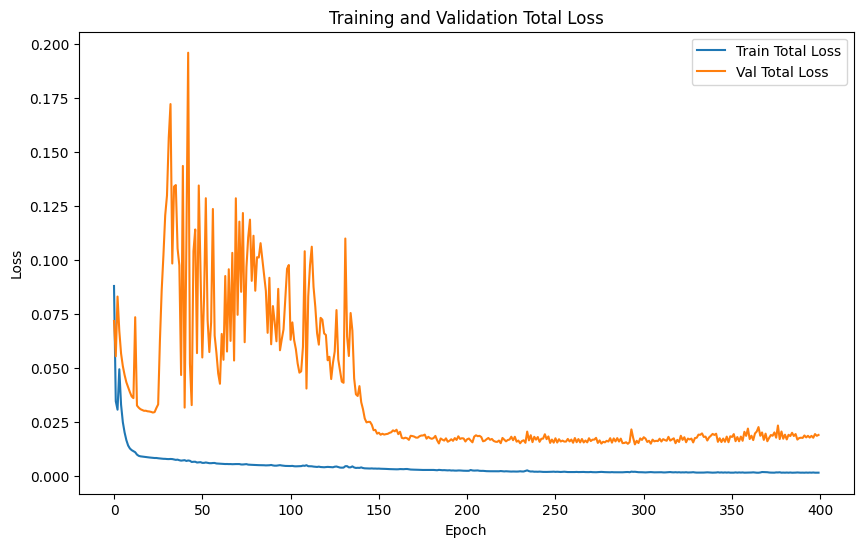

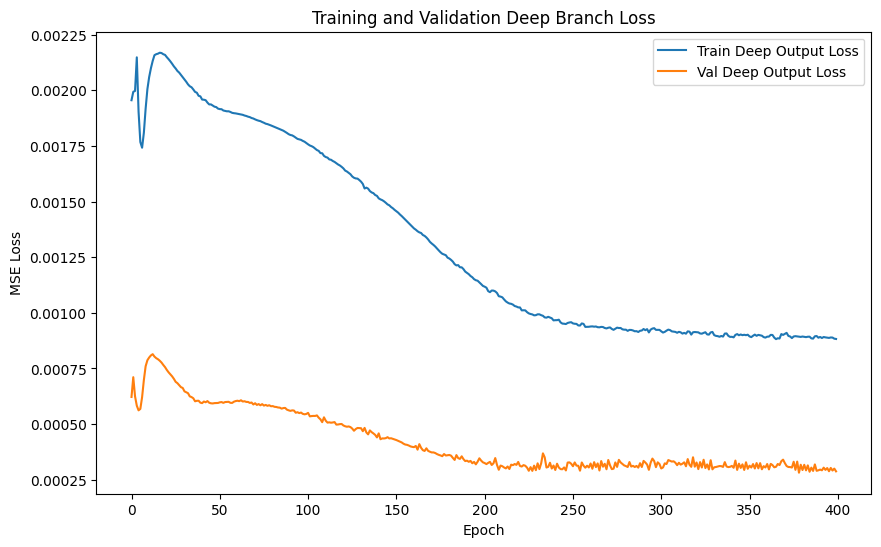

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, constraints
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# ---------------- Data Preparation ----------------
# Assume acsm_scaled_shifted_df is your normalized DataFrame with shape (num_samples, 43)
X = acsm_scaled_shifted_df.values   # shape: (num_samples, 43)
# The encoder expects input shape (43, 1)
X_input = np.expand_dims(X, axis=-1)  # shape: (num_samples, 43, 1)
# Target for reconstruction: original spectrum (num_samples, 43)
X_target = X

n_clusters = 3

# -------------- Custom Helper Layers --------------

class IdentityLayer(layers.Layer):
    def call(self, inputs):
        return tf.identity(inputs)

class ConsistencyLossLayer(layers.Layer):
    """
    Computes cosine similarity loss between deep_output and linear_output,
    then adds the loss (weighted by self.weight) via self.add_loss.
    """
    def __init__(self, weight, **kwargs):
        super().__init__(**kwargs)
        self.weight = weight

    def call(self, inputs):
        deep_out, linear_out = inputs
        y_true_norm = tf.nn.l2_normalize(deep_out, axis=-1)
        y_pred_norm = tf.nn.l2_normalize(linear_out, axis=-1)
        cosine_sim = tf.reduce_sum(y_true_norm * y_pred_norm, axis=-1)
        loss_val = 1 - cosine_sim
        loss_val = tf.reduce_mean(loss_val)
        self.add_loss(self.weight * loss_val)
        return inputs

class CorrelationLossLayer(layers.Layer):
    """
    Computes correlation loss between the input (squeezed) and the deep branch output.
    """
    def __init__(self, weight, **kwargs):
        super().__init__(**kwargs)
        self.weight = weight

    def call(self, inputs):
        model_input, deep_out = inputs
        x_true = tf.squeeze(model_input, axis=-1)  # from (batch, 43, 1) to (batch, 43)
        mean_true = tf.reduce_mean(x_true, axis=0, keepdims=True)
        mean_pred = tf.reduce_mean(deep_out, axis=0, keepdims=True)
        x_true_centered = x_true - mean_true
        x_pred_centered = deep_out - mean_pred
        batch_size = tf.cast(tf.shape(x_true)[0], tf.float32)
        cov_true = tf.matmul(tf.transpose(x_true_centered), x_true_centered) / (batch_size - 1)
        cov_pred = tf.matmul(tf.transpose(x_pred_centered), x_pred_centered) / (batch_size - 1)
        std_true = tf.sqrt(tf.linalg.diag_part(cov_true))
        std_pred = tf.sqrt(tf.linalg.diag_part(cov_pred))
        corr_true = cov_true / (std_true[:, None] * std_true[None, :] + 1e-8)
        corr_pred = cov_pred / (std_pred[:, None] * std_pred[None, :] + 1e-8)
        loss_val = tf.reduce_mean(tf.square(corr_true - corr_pred))
        self.add_loss(self.weight * loss_val)
        return deep_out

# Loss weight hyperparameters
lambda1 = 0.5  # consistency loss weight
lambda2 = 0.6  # correlation loss weight # best is 0.6

# -------------- Build Enhanced Models --------------
# (Assuming build_encoder() and build_dual_decoder() are defined as in our previous design)
encoder = build_encoder(n_clusters=n_clusters, input_shape=(43,1))
dual_decoder = build_dual_decoder(n_clusters=n_clusters, input_dim=43)

def build_autoencoder(encoder, dual_decoder):
    inputs = layers.Input(shape=(43,1), name="AE_Input")
    latent = encoder(inputs)
    deep_output, linear_output = dual_decoder(latent)

    # Wrap outputs with IdentityLayer to assign names
    deep_out_named = IdentityLayer(name="deep_output")(deep_output)
    linear_out_named = IdentityLayer(name="linear_output")(linear_output)

    # Add consistency loss: align linear_output with deep_output.
    consistency_outputs = ConsistencyLossLayer(lambda1)([deep_out_named, linear_out_named])

    # Add correlation loss: compare model input (squeezed) with deep_output.
    deep_final = CorrelationLossLayer(lambda2)([inputs, consistency_outputs[0]])

    # For supervised training, we output both deep and linear outputs in a dictionary.
    return models.Model(inputs, {"deep_output": deep_final, "linear_output": consistency_outputs[1]}, name="Autoencoder")

autoencoder = build_autoencoder(encoder, dual_decoder)

# -------------- Compile the Model --------------
# We supervise only the deep branch using MSE; the additional losses have been added internally.
autoencoder.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss={"deep_output": "mse", "linear_output": "mse"},
    loss_weights={"deep_output": 1.0, "linear_output": 0.0}
)

# -------------- Train the Autoencoder --------------
history = autoencoder.fit(
    X_input,
    {"deep_output": X_target, "linear_output": X_target},
    epochs=400,
    batch_size=512,
    validation_split=0.25
)

# -------------- Plot Training History --------------
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Total Loss')
plt.plot(history.history['val_loss'], label='Val Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Total Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['deep_output_loss'], label='Train Deep Output Loss')
plt.plot(history.history['val_deep_output_loss'], label='Val Deep Output Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Deep Branch Loss')
plt.legend()
plt.show()


### Save and Load Model

In [ ]:
autoencoder.save('autoencoder_model.h5')

In [ ]:
# Retrieve the linear branch layer from the dual decoder
linear_layer = dual_decoder.get_layer('linear_output')
W = linear_layer.get_weights()[0]  # Extract the kernel weights

# Save the weight matrix to a file (e.g., .npy format)
np.save('linear_weights.npy', W)

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError

custom_objs = {
    'IdentityLayer': IdentityLayer,
    'ConsistencyLossLayer': ConsistencyLossLayer,
    'CorrelationLossLayer': CorrelationLossLayer,
    'ClusteringLayer': ClusteringLayer,
    'mse': MeanSquaredError()
}

autoencoder_loaded = load_model('autoencoder_model.h5', custom_objects=custom_objs)


### Visualisation For AutoEncoder

In [ ]:
W_loaded = np.load('linear_weights.npy')
W_loaded.shape

(3, 43)

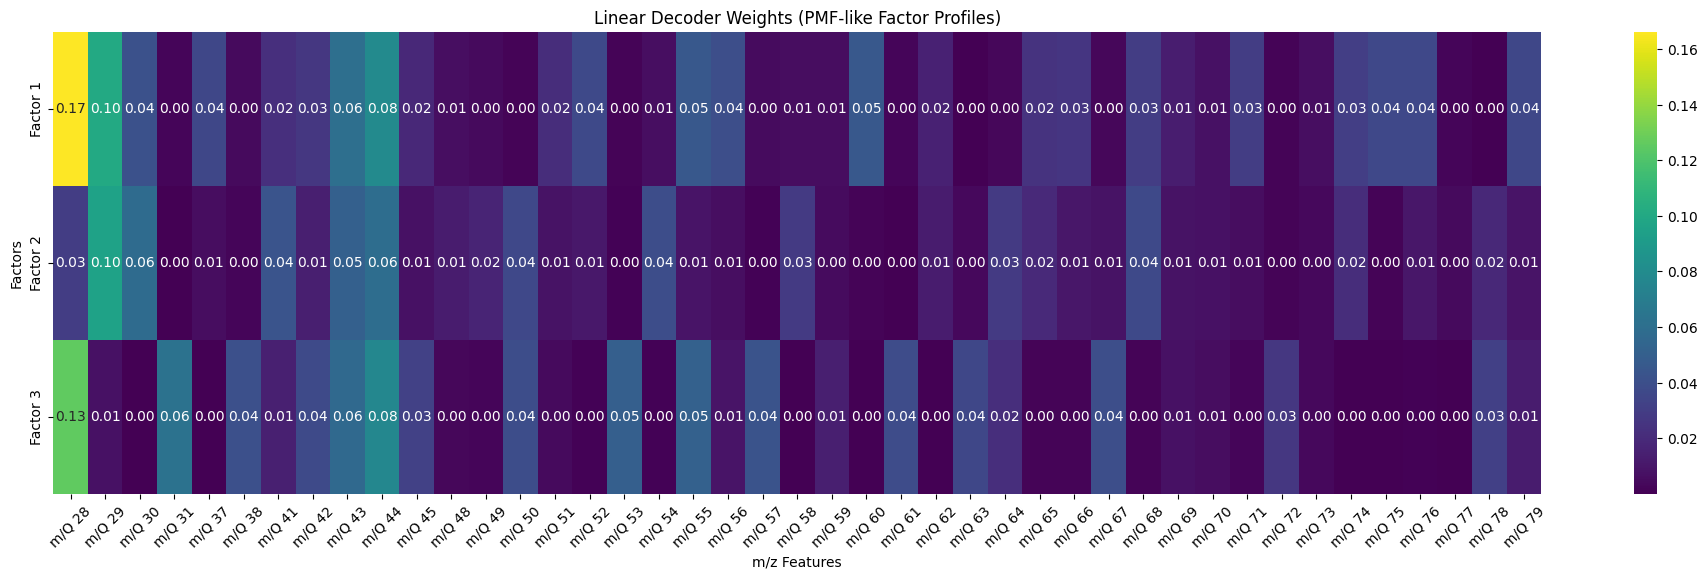

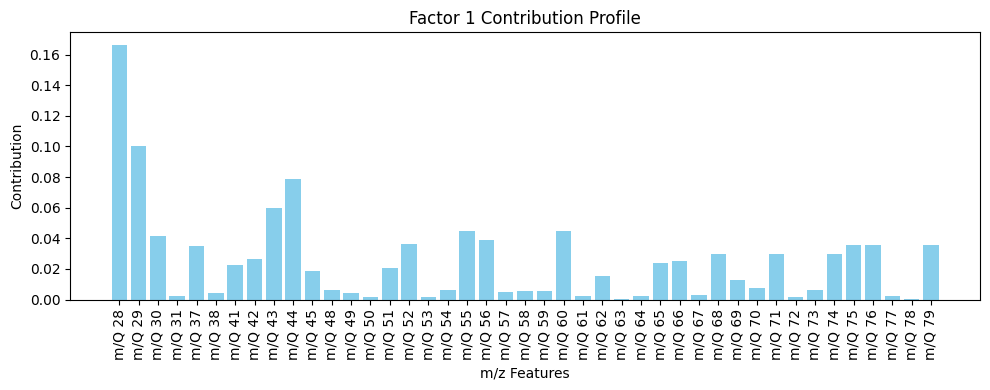

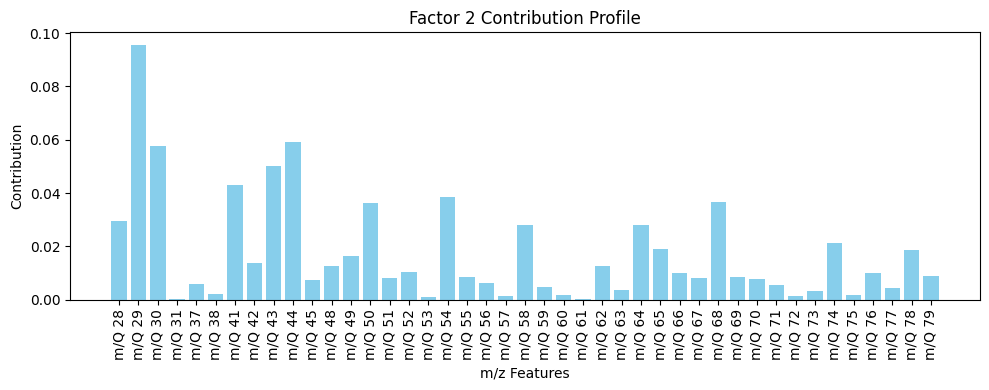

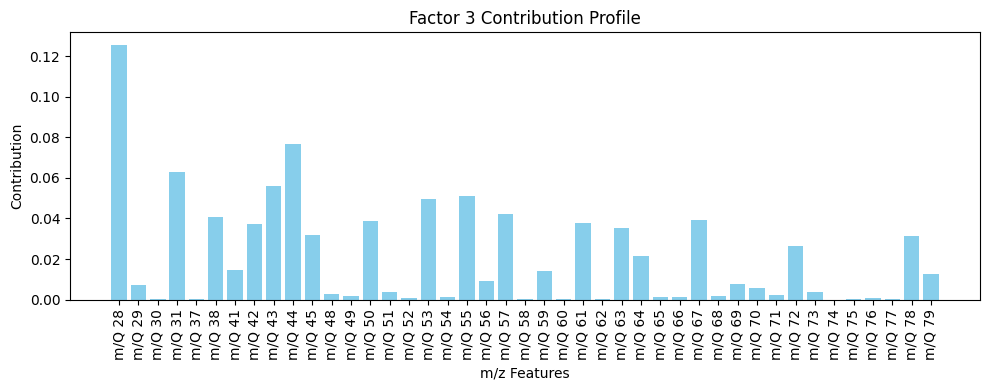

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


W_loaded = np.load('linear_weights.npy')

# # Retrieve the linear branch layer from our dual_decoder
# linear_layer = dual_decoder.get_layer("linear_output")
# # Get the weights (kernel only)
# W = linear_layer.get_weights()[0]
# print("Weight matrix shape:", W.shape)  # Expected shape: (n_clusters, 43)

# # Check statistics for the kernel weights
# kernel, bias = linear_layer.get_weights()
# print("Kernel shape:", kernel.shape)
# print("Kernel stats: min =", np.min(kernel), "max =", np.max(kernel))

# tolerance = 1e-7
# if np.any(kernel < -tolerance):
#     print("Significant negative values found in the kernel.")
# else:
#     print("Negatives are within numerical precision limits.")

W= W_loaded

# List of the 43 m/z features
feature_names = [
    'm/Q 28', 'm/Q 29', 'm/Q 30', 'm/Q 31', 'm/Q 37', 'm/Q 38', 'm/Q 41',
    'm/Q 42', 'm/Q 43', 'm/Q 44', 'm/Q 45', 'm/Q 48', 'm/Q 49', 'm/Q 50',
    'm/Q 51', 'm/Q 52', 'm/Q 53', 'm/Q 54', 'm/Q 55', 'm/Q 56', 'm/Q 57',
    'm/Q 58', 'm/Q 59', 'm/Q 60', 'm/Q 61', 'm/Q 62', 'm/Q 63', 'm/Q 64',
    'm/Q 65', 'm/Q 66', 'm/Q 67', 'm/Q 68', 'm/Q 69', 'm/Q 70', 'm/Q 71',
    'm/Q 72', 'm/Q 73', 'm/Q 74', 'm/Q 75', 'm/Q 76', 'm/Q 77', 'm/Q 78',
    'm/Q 79'
]

# Create labels for the latent factors (sources)
factor_labels = [f'Factor {i+1}' for i in range(W.shape[0])]

# Plot a heatmap of the weight matrix
plt.figure(figsize=(24, 6))
sns.heatmap(W, annot=True, cmap="viridis", fmt=".2f",
            xticklabels=feature_names, yticklabels=factor_labels)
plt.xlabel("m/z Features")
plt.ylabel("Factors")
plt.title("Linear Decoder Weights (PMF-like Factor Profiles)")
plt.xticks(rotation=45)
plt.show()

# Plot individual bar charts for each factor
for i in range(W.shape[0]):
    plt.figure(figsize=(10, 4))
    plt.bar(feature_names, W[i, :], color='skyblue')
    plt.xticks(rotation=90)
    plt.xlabel("m/z Features")
    plt.ylabel("Contribution")
    plt.title(f"Factor {i+1} Contribution Profile")
    plt.tight_layout()
    plt.show()


### Comparision

In [ ]:
import pandas as pd

# Load the CSV file
nmf_df = pd.read_csv("NMF_Factor_Profiles.csv", index_col=0)

print("Shape of nmf_df:", nmf_df.shape)
print("Dataframe preview:")
display(nmf_df.head())  # or print(nmf_df.head()) if display isn't available

# Expecting shape: (3, 43)
#   - i.e., 3 factor rows, 43 species columns
#
# Also check that the index has something like:
#    Factor1
#    Factor2
#    Factor3
# and the columns are the m/Q species names, e.g. "m/Q 28", "m/Q 29", ...


Shape of nmf_df: (3, 43)
Dataframe preview:


,m/Q 28,m/Q 29,m/Q 30,m/Q 31,m/Q 37,m/Q 38,m/Q 41,m/Q 42,m/Q 43,m/Q 44,...,m/Q 70,m/Q 71,m/Q 72,m/Q 73,m/Q 74,m/Q 75,m/Q 76,m/Q 77,m/Q 78,m/Q 79
Factor 1,1.785784,1.119007,0.024618,0.359236,0.042228,0.071774,0.503211,0.408799,1.176089,1.785784,...,0.072301,0.179207,0.031289,0.183537,0.038761,0.013643,0.021060,0.062999,0.014060,0.052414
Factor 2,0.000000,0.363764,0.008003,0.051148,0.021431,0.039389,0.393829,0.160814,0.793848,0.000000,...,0.061030,0.108760,0.019180,0.008952,0.009543,0.011672,0.012853,0.048635,0.021922,0.069671
Factor 3,1.400912,0.364047,0.008009,0.123451,0.020612,0.036172,0.161993,0.202640,0.609229,1.400912,...,0.027089,0.034721,0.018797,0.016457,0.013206,0.012969,0.019785,0.023495,0.013712,0.048687


In [ ]:
import numpy as np

W_auto = np.load("linear_weights.npy")
print("Shape of W_auto:", W_auto.shape)

# Expecting shape: (3, 43)
# The first dimension = 3 factors (e.g. AE_Factor1, AE_Factor2, AE_Factor3)
# The second dimension = 43 species


Shape of W_auto: (3, 43)


In [ ]:
# If the row index is just [0,1,2], rename them to factor names.
nmf_df.index = ["NMF_Factor1", "NMF_Factor2", "NMF_Factor3"]

# For the autoencoder weights, you might do:
import pandas as pd

AE_df = pd.DataFrame(W_auto,
                     index=["AE_Factor1", "AE_Factor2", "AE_Factor3"],
                     columns=nmf_df.columns)  # if you want the same species columns


In [ ]:
def row_normalize_sum(df):
    """
    Row-normalize the DataFrame so each row sums to 1.
    Rows that sum to 0 remain unchanged.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame where rows represent factors and columns represent species (m/z).

    Returns
    -------
    df_norm : pd.DataFrame
        A copy of the input DataFrame, but each row is normalized so that its values sum to 1.
    """
    df_norm = df.copy()
    for idx in df_norm.index:
        row_sum = df_norm.loc[idx].sum()
        if row_sum != 0:
            df_norm.loc[idx] = df_norm.loc[idx] / row_sum
    return df_norm



nmf_df_norm = row_normalize_sum(nmf_df)
ae_df_norm  = row_normalize_sum(AE_df)

# Now each row in both DataFrames sums to 1, making them comparable.
print(nmf_df_norm.sum(axis=1))  # Should print 1.0 for each row
print(ae_df_norm.sum(axis=1))   # Same here

NMF_Factor1    1.0
NMF_Factor2    1.0
NMF_Factor3    1.0
dtype: float64
AE_Factor1    1.0
AE_Factor2    1.0
AE_Factor3    1.0
dtype: float32


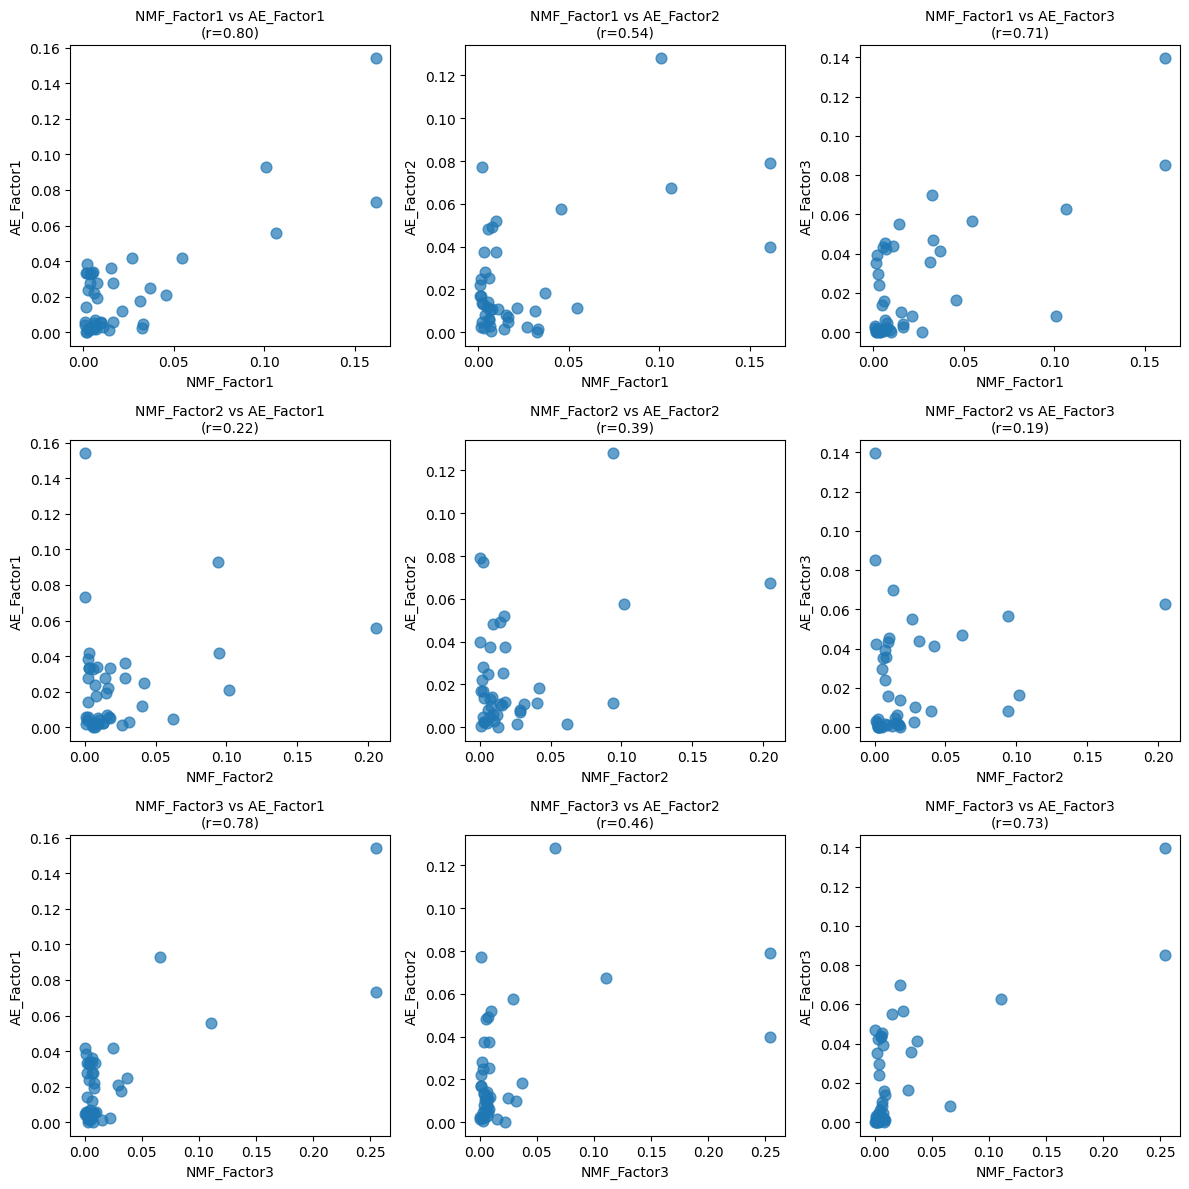

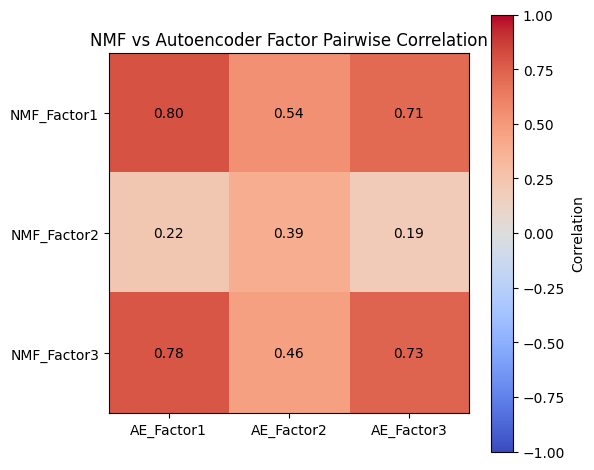

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# 1. Compute Pairwise Correlation Matrix
# -------------------------
corr_matrix = np.zeros((3, 3))
nmf_factors = nmf_df_norm.index.tolist()   # e.g. ['NMF_Factor1', 'NMF_Factor2', 'NMF_Factor3']
ae_factors  = ae_df_norm.index.tolist()    # e.g. ['AE_Factor1', 'AE_Factor2', 'AE_Factor3']

for i in range(3):
    for j in range(3):
        nmf_vec = nmf_df_norm.iloc[i].values  # Row i from NMF
        ae_vec  = ae_df_norm.iloc[j].values   # Row j from AE
        # Pearson correlation
        corr = np.corrcoef(nmf_vec, ae_vec)[0, 1]
        corr_matrix[i, j] = corr

# -------------------------
# 2. Scatter Plot Grid (3x3)
# -------------------------
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))

for i in range(3):
    for j in range(3):
        ax = axes[i, j]
        nmf_vec = nmf_df_norm.iloc[i].values
        ae_vec  = ae_df_norm.iloc[j].values
        ax.scatter(nmf_vec, ae_vec, s=60, alpha=0.7)

        # Optionally label each point with the species name:
        # species_names = nmf_df_norm.columns
        # for k in range(len(species_names)):
        #     ax.text(nmf_vec[k], ae_vec[k], species_names[k], fontsize=8)

        # Title with correlation
        r = corr_matrix[i, j]
        ax.set_title(f"{nmf_factors[i]} vs {ae_factors[j]}\n(r={r:.2f})", fontsize=10)

        # Axis labels
        ax.set_xlabel(nmf_factors[i])
        ax.set_ylabel(ae_factors[j])

plt.tight_layout()
plt.show()

# -------------------------
# 3. Heatmap of Correlation
# -------------------------
plt.figure(figsize=(6, 5))
plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.xticks(range(3), ae_factors)
plt.yticks(range(3), nmf_factors)
plt.colorbar(label='Correlation')
plt.title("NMF vs Autoencoder Factor Pairwise Correlation")

# Annotate each cell
for i in range(3):
    for j in range(3):
        plt.text(j, i, f"{corr_matrix[i,j]:.2f}",
                 ha='center', va='center', color='black')

plt.tight_layout()
plt.show()


In [ ]:
def plot_difference_and_ratio(nmf_df_norm, ae_df_norm,
                              nmf_factor="NMF_Factor1",
                              ae_factor="AE_Factor1"):
    """
    Plots two bar charts:
      1) Difference: nmf_factor - ae_factor
      2) Ratio: nmf_factor / ae_factor (watch out for small denominators)
    Both from row-normalized DataFrames.

    Parameters
    ----------
    nmf_df_norm : pd.DataFrame
        Row-normalized DataFrame of shape (3, 43) for the NMF solution.
        Rows = NMF_Factor1, NMF_Factor2, NMF_Factor3
        Columns = the m/z species
    ae_df_norm : pd.DataFrame
        Row-normalized DataFrame of shape (3, 43) for the Autoencoder solution.
        Rows = AE_Factor1, AE_Factor2, AE_Factor3
        Columns = the m/z species (same order as nmf_df_norm)
    nmf_factor : str
        The name of the NMF factor row to compare (e.g. "NMF_Factor1")
    ae_factor : str
        The name of the AE factor row to compare (e.g. "AE_Factor1")
    """

    # 1. Extract the species columns and ensure they match
    species = nmf_df_norm.columns
    assert (species == ae_df_norm.columns).all(), "NMF and AE DataFrames must have identical columns."

    # 2. Retrieve the selected factor rows
    nmf_values = nmf_df_norm.loc[nmf_factor].values
    ae_values  = ae_df_norm.loc[ae_factor].values

    # 3. Compute difference and ratio
    difference = nmf_values - ae_values
    # For ratio, handle small or zero denominators carefully
    ratio = np.where(ae_values > 1e-12, nmf_values / ae_values, np.nan)  # or some small threshold

    # 4. Plot the difference in a bar chart
    plt.figure(figsize=(12, 4))
    plt.bar(species, difference, color='skyblue', alpha=0.8)
    plt.axhline(0, color='black', linewidth=1)
    plt.title(f"Difference: {nmf_factor} - {ae_factor}")
    plt.xlabel("m/z Species")
    plt.ylabel("Difference (NMF - AE)")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    # 5. Plot the ratio in another bar chart
    plt.figure(figsize=(12, 4))
    plt.bar(species, ratio, color='salmon', alpha=0.8)
    plt.axhline(1, color='black', linewidth=1, linestyle='--')
    plt.title(f"Ratio: {nmf_factor} / {ae_factor}")
    plt.xlabel("m/z Species")
    plt.ylabel("Ratio (NMF ÷ AE)")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


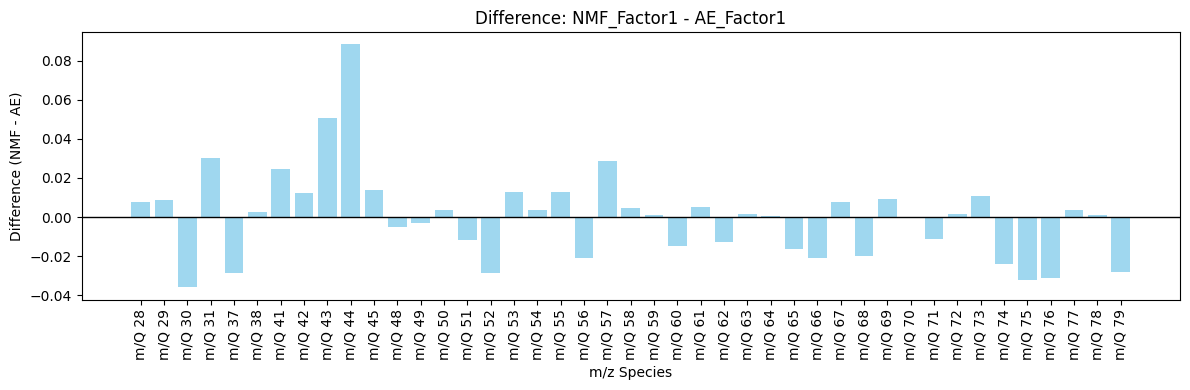

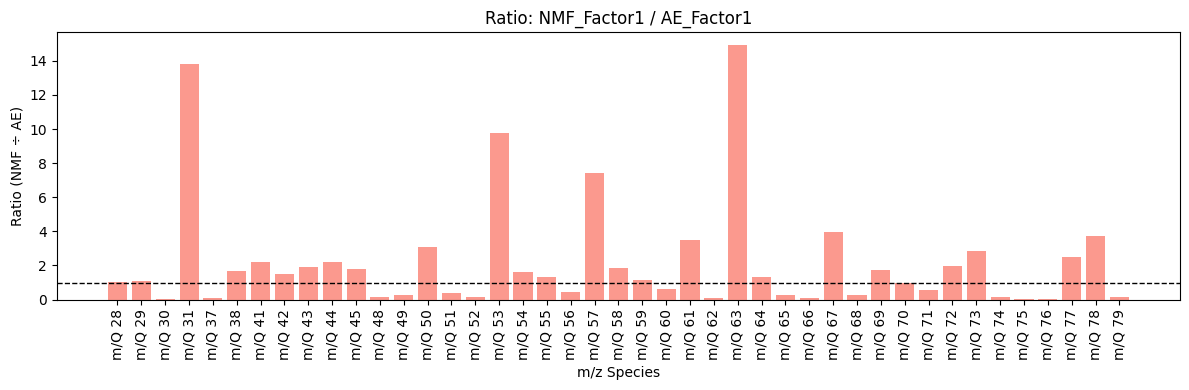

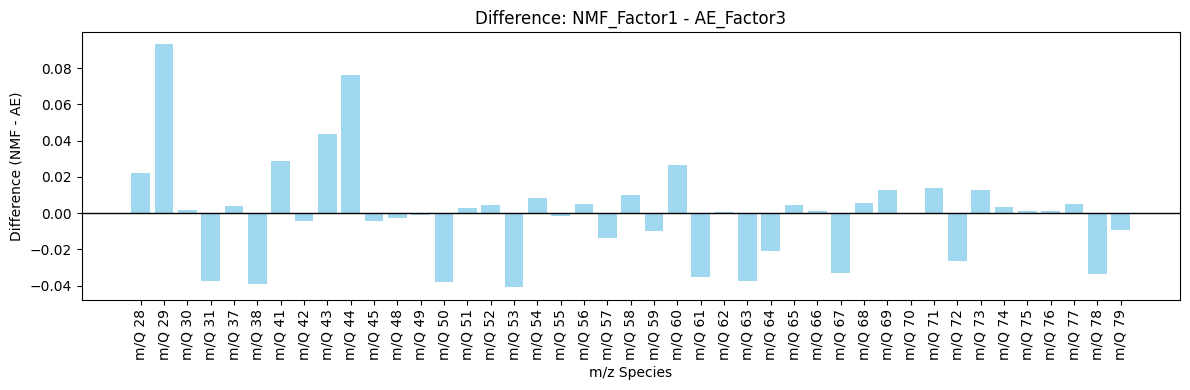

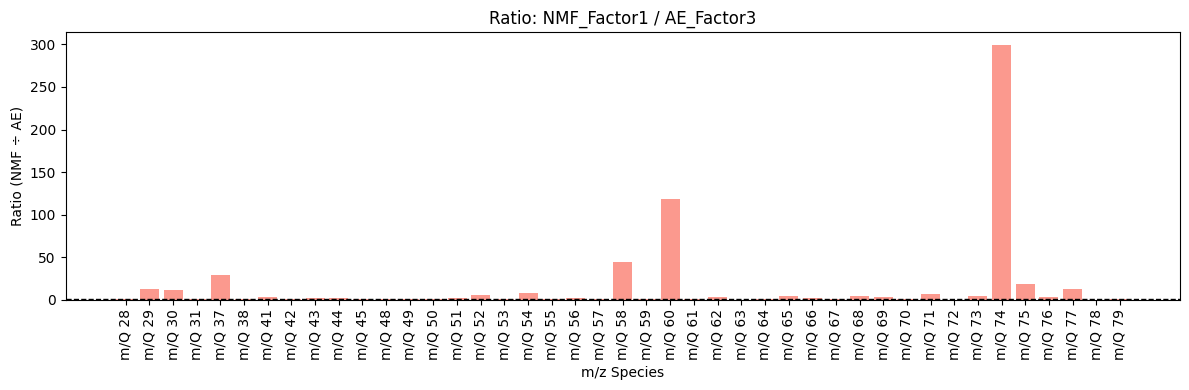

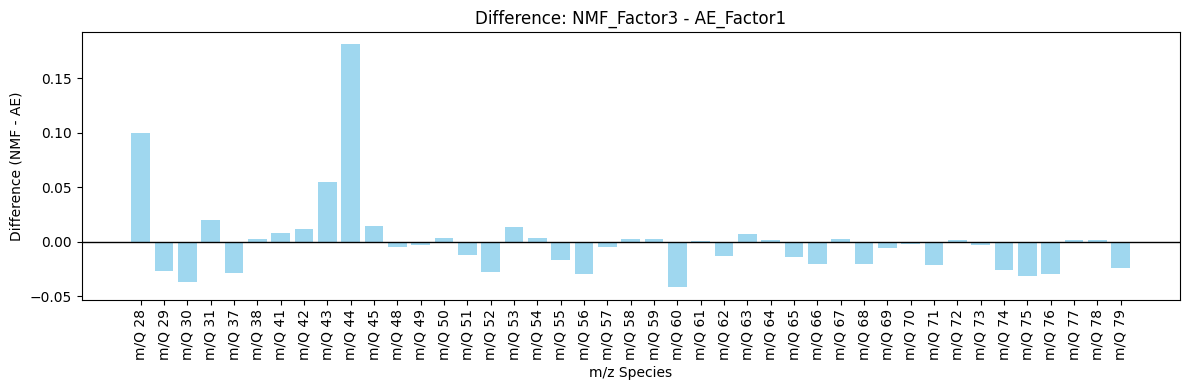

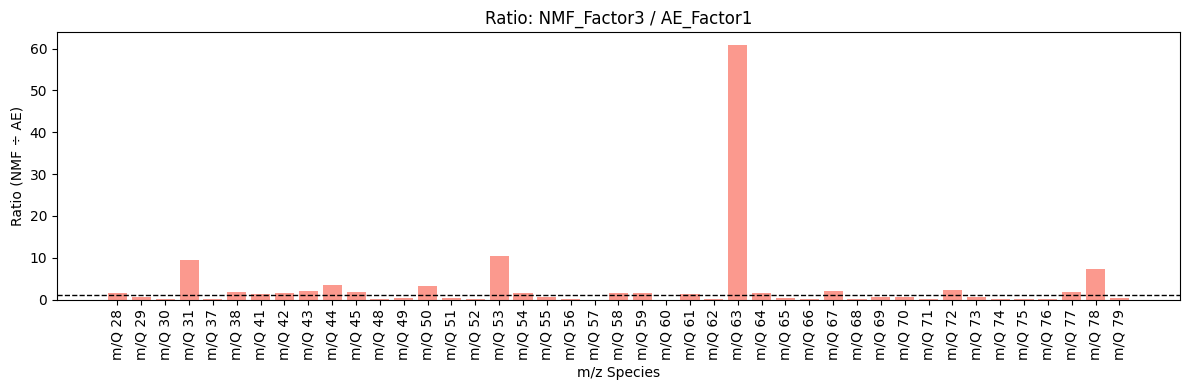

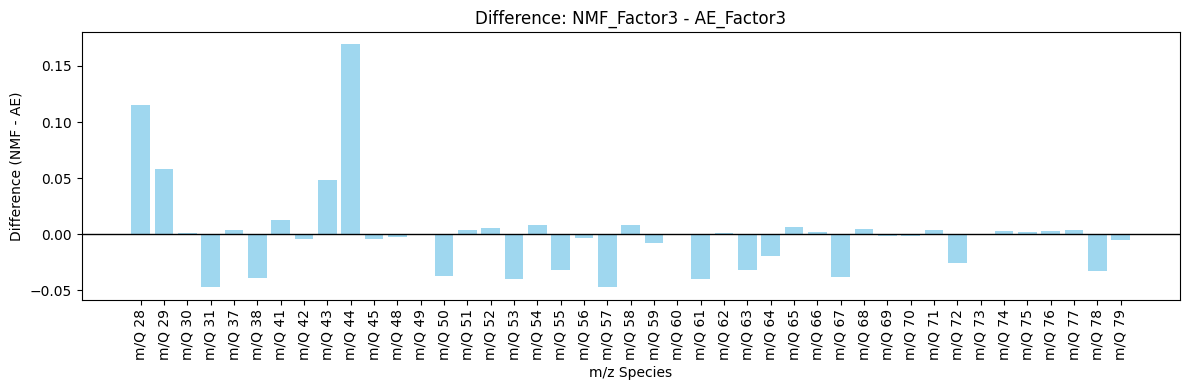

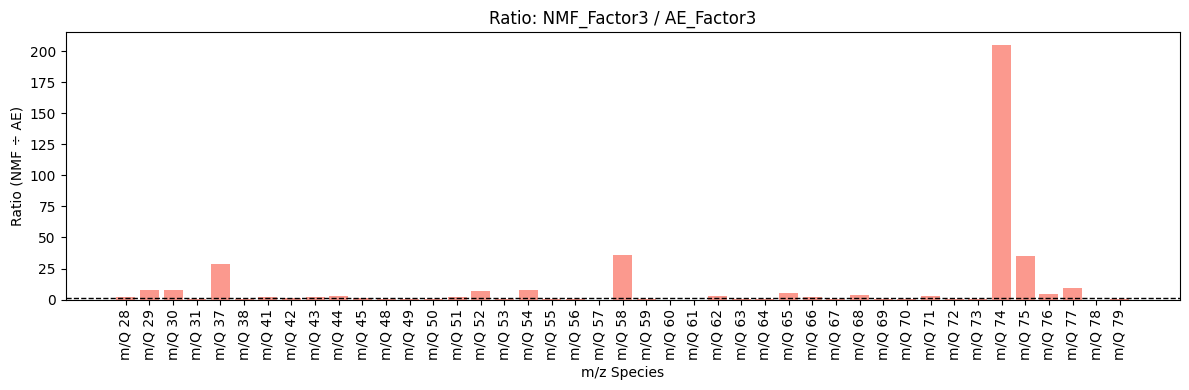

In [ ]:
plot_difference_and_ratio(nmf_df_norm, ae_df_norm, "NMF_Factor1", "AE_Factor1")
plot_difference_and_ratio(nmf_df_norm, ae_df_norm, "NMF_Factor1", "AE_Factor3")
plot_difference_and_ratio(nmf_df_norm, ae_df_norm, "NMF_Factor3", "AE_Factor1")
plot_difference_and_ratio(nmf_df_norm, ae_df_norm, "NMF_Factor3", "AE_Factor3")

### Training Joint Model With KL Divergence

In [ ]:
from sklearn.cluster import KMeans

# -------------------------------
# 1. Build the Full DCEC Model
# -------------------------------
n_clusters = 4  # Use same as your pretrained model
dcec_model, encoder, decoder = build_dcec_model(n_clusters=n_clusters, input_shape=(43,1))

# -------------------------------
# 2. Initialize Cluster Centers via KMeans
# -------------------------------
# Get latent representations for all samples
latent_features = encoder.predict(X)
print("Latent features shape:", latent_features.shape)  # Expected: (num_samples, n_clusters)

# Use KMeans to get initial centers
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(latent_features)
initial_cluster_centers = kmeans.cluster_centers_
print("Initial cluster centers shape:", initial_cluster_centers.shape)

# Set the cluster centers in the ClusteringLayer
clustering_layer = dcec_model.get_layer(name='clustering')
clustering_layer.set_weights([initial_cluster_centers])

# -------------------------------
# 3. Define Target Distribution and Clustering Loss
# -------------------------------
def target_distribution(q):
    """
    Compute the target distribution p, given soft assignments q.
    This function sharpens the probabilities to guide training.
    """
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

def similarity_loss(y_true, y_pred):
    # Here, y_true and y_pred will be the deep and linear outputs.
    return tf.reduce_mean(tf.square(y_true - y_pred))

def clustering_loss(y_true, y_pred):
    """
    KL divergence loss between target distribution (y_true) and soft assignments (y_pred).
    """
    return K.mean(K.sum(y_true * K.log((y_true + 1e-10) / (y_pred + 1e-10)), axis=1))

# -------------------------------
# 4. Compile the Full DCEC Model
# -------------------------------
# Here we combine reconstruction loss (MSE) with clustering loss.
dcec_model.compile(
    optimizer='adam',
    loss={
        "deep_output": "mse",
        "linear_output": similarity_loss,
        "clustering": lambda y_true, y_pred: 0.0  # or use your KL divergence loss later
    },
    loss_weights={
        "deep_output": 1.0,
        "linear_output": 0.1,  # adjust weight to control the influence of similarity constraint
        "clustering": 1.0
    }
)

# -------------------------------
# 5. Joint Training with Per-Epoch Target Updates
# -------------------------------
epochs = 50
batch_size = 256

for epoch in range(epochs):
    # Get current soft assignments (q) from the clustering branch:
    q = dcec_model.predict(X, batch_size=batch_size)[1]
    # Update the target distribution (p):
    p = target_distribution(q)

    print(f"Epoch {epoch+1}/{epochs}: Updating target distribution and training for one epoch.")

    # Train for one epoch using the updated target distribution for the clustering branch.
    dcec_model.fit(
        X,
        [X, p],
        batch_size=batch_size,
        epochs=1,
        validation_split=0.25,
        verbose=1
    )



479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Latent features shape: (15301, 4)
Initial cluster centers shape: (4, 4)
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/50: Updating target distribution and training for one epoch.
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - Decoder_loss: 0.0016 - clustering_loss: 3.7165e-06 - loss: 0.0016 - val_Decoder_loss: 1.1742e-04 - val_clustering_loss: 1.0452e-07 - val_loss: 1.1735e-04
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 2/50: Updating target distribution and training for one epoch.
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Decoder_loss: 4.9770e-04 - clustering_loss: 2.2889e-06 - loss: 5.0003e-04 - val_Decoder_loss: 1.2825e-04 - val_clustering_loss: 1.5933e-07 - val_loss: 1.2784e-04
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 3/50: Updating target distribution and training for one epoch.
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Decoder_loss: 3.0456e-04 - clustering_loss: 6.4919e-06 - loss: 3.1105e-04 - val_Decoder_loss: 8.1547e-05 - val_clustering_